In [ ]:
import astropy.table as at
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
data = at.Table.read("../data/heteroskedastic-1024.csv")
data[:5]

x,y,y_err
float64,float64,float64
7.513516534115597,-17.664323995215522,7.85364378672189
3.8276628372725754,-11.971760923377442,0.5403448008901698
8.444577119025206,-33.4915228724344,2.999310482556568
6.671048319653003,-22.392359596254988,0.6401480225017683
0.03595082676414485,3.889633419220786,1.3293454705002776


<ErrorbarContainer object of 3 artists>

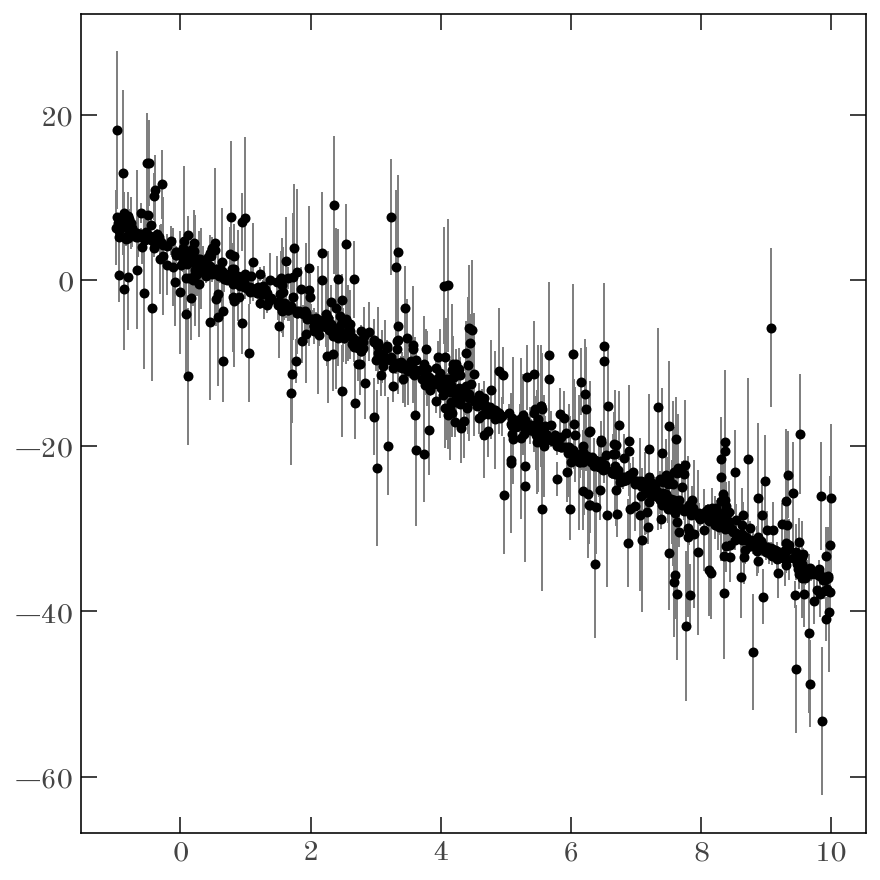

In [ ]:
plt.errorbar(
    data["x"],
    data["y"],
    yerr=data["y_err"],
    fmt="o",
    color="k",
    ecolor="gray",
    elinewidth=1,
    capsize=0,
)